# InfoGAN analysis

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from ipywidgets import interact, fixed
import ipywidgets as widgets
import numpy as np

import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision

import pickle
import interpolation as itp

In [4]:
class Generator64(nn.Module):
    def __init__(self, latent_dim, n_feature_maps, n_channels):
        super(Generator64, self).__init__()
        self.main = nn.Sequential(
            #1x1
            nn.ConvTranspose2d(latent_dim, 8*n_feature_maps, 4, 1, 0, bias=False),
            nn.BatchNorm2d(8*n_feature_maps),
            nn.ReLU(True),
            #4x4
            nn.ConvTranspose2d(8*n_feature_maps, 4*n_feature_maps, 4, 2, 1, bias=False),
            nn.BatchNorm2d(4*n_feature_maps),
            nn.ReLU(True),
            #8x8
            nn.ConvTranspose2d(4*n_feature_maps, 2*n_feature_maps, 4, 2, 1, bias=False),
            nn.BatchNorm2d(2*n_feature_maps),
            nn.ReLU(True),
            #16x16
            nn.ConvTranspose2d(2*n_feature_maps, n_feature_maps, 4, 2, 1, bias=False),
            nn.BatchNorm2d(n_feature_maps),
            nn.ReLU(True),
            #32x32
            nn.ConvTranspose2d(n_feature_maps, n_channels, 4, 2, 1, bias=False),
            #64x64
            nn.Tanh()
        )
        
    def  forward(self, z, c):
        x = torch.cat([z,c],1)
        return self.main(x)
    

class Code:
    def __init__(self, n_classes, n_continuous, type_continuous='uniform'):
        """
        Class representing the code of InfoGAN, i.e. the meaningful part of the latent representation.
        There are 2 parts to consider: the discrete random variable and the continuous ones.
        
        n_classes: number of classes for the discrete random variables
        n_continuous: number of continuous dimensions in the code
        type_continuous: whether the continuous variables follow a uniform or normal distribution
        """

        self.n_classes = n_classes
        if n_classes > 0:
            self.dis_entropy = np.log(n_classes)
        else:
            self.dis_entropy = 0
        
        self.type_continuous = type_continuous
        self.n_continuous = n_continuous
        if type_continuous == 'normal':
            self.con_entropy = n_continuous/2 * np.log(2*np.pi*np.e) # entropy of N(0,1) x number of variables
        else:
            self.con_entropy = n_continuous * np.log(2) # entropy of  U([-1,1]) x number of variables
        
        self.latent_size = self.n_classes + self.n_continuous # dimension in latent space (with onehot encoding)
        self.param_size = self.n_classes + 2 * self.n_continuous # dimension needed to specify distribution (2 params per Gaussian)
        self.entropy = self.dis_entropy + self.con_entropy # distribution factorises so entropy is sum of entropies
            
    def sample_discrete(self, batch_size):
        if self.n_classes > 0:
            c = np.random.multinomial(1, self.n_classes*[1/self.n_classes], size=batch_size)
            return torch.from_numpy(c.astype(np.float32))
        else:
            return torch.Tensor([])
    
    def sample_continuous(self, batch_size):
        if self.n_continuous > 0:
            if self.type_continuous == 'uniform':
                c = torch.FloatTensor(batch_size, self.n_continuous).uniform_(-1,1)
            else:
                c = torch.FloatTensor(batch_size, self.n_continuous).normal_(0,1)
            
            return c
            
        else:
            return torch.Tensor([])
    
    def sample(self, batch_size):
        dis = self.sample_discrete(batch_size)
        con = self.sample_continuous(batch_size)
        return torch.cat([dis, con], 1)

    def get_logits(self, Qc_x):
        return Qc_x[:,:self.n_classes]

    def get_gaussian_values(self, c):
        return c[:,self.n_classes:]
        
    def get_gaussian_params(self, Qc_x):
        mean_end_idx = self.n_classes + self.n_continuous
        mean  = Qc_x[:, self.n_classes:mean_end_idx]
        log_var = Qc_x[:,mean_end_idx:]
        return mean, torch.exp(log_var)

In [5]:
code = Code(0, 2, 'uniform')
latent_size = 100
z_size = latent_size - code.latent_size

In [6]:
#G = Generator32(latent_size, 64, 1)
#G.load_state_dict(torch.load('results/saved_data/mnist_InfoGAN2_64_generator', map_location=lambda storage, loc: storage))
#G = Generator32(latent_size, 128, 3)
#G.load_state_dict(torch.load('results/saved_data/cifar_InfoGAN_128_generator', map_location=lambda storage, loc: storage))
#G = Generator64(latent_size, 128, 3)
#G.load_state_dict(torch.load('results/saved_data/paintings64_InfoGAN_128_generator', map_location=lambda storage, loc: storage))
#G = Generator(100, 128)
#G.load_state_dict(torch.load('results/saved_data/paintings64_DCGAN_fm2_128_generator', map_location=lambda storage, loc: storage))
G = Generator64(100, 128, 3)
G.load_state_dict(torch.load('../results/saved_data/regular_savepaintings64_InfoGAN3_epoch_60_generator', map_location=lambda storage, loc: storage))

In [7]:
def sample_z(batch_size, zdim=100):
    return torch.FloatTensor(batch_size, zdim, 1, 1).normal_()

def show_result(z, c=None, G=G):
    
    z = Variable(z, volatile=True)
    if c is not None:
        c = Variable(c, volatile=True)
        samples = G(z,c).data.numpy()
    else:
        samples = G(z).data.numpy()
        
    samples = samples.transpose(0, 2, 3, 1)
    samples = (samples + 1) / 2
    n_samples = samples.shape[0]
    #n_columns = min(n_samples, 10)
    #n_rows = 1 + n_samples//n_columns - (n_samples%n_columns==0)
    
    n_side = int(np.sqrt(n_samples)) + 1 - (n_samples == int(np.sqrt(n_samples))**2)
    fig_side = min(3*n_side, 18)
    
    if n_samples == 1:
        if samples[0].shape[-1] == 1:
            plt.imshow(samples[0].squeeze(), cmap='gray')
        else:
            plt.imshow(samples[0].squeeze())
        return 
    
    fig, ax = plt.subplots(n_side, n_side, figsize=(fig_side, fig_side))
    for i in range(n_side):
        for j in range(n_side):
            ax[i, j].get_xaxis().set_visible(False)
            ax[i, j].get_yaxis().set_visible(False)
            ax[i, j].cla()
            k = i*n_side + j
            if k >= len(samples):
                break
            else:
                if samples[k].shape[-1] == 1:
                    ax[i, j].imshow(samples[k].squeeze(), cmap='gray')
                else:
                    ax[i, j].imshow(samples[k])
    
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

def show_interpolation(z1, z2, n, mode = 'lerp', G=G):
    z1 = z1.view(1,-1,1,1)
    z2 = z2.view(1,-1,1,1)
    vals = np.linspace(0, 1, n)
    z = torch.Tensor([])
    for v in vals:
        if mode == 'lerp':
            res = itp.lerp(v, z1, z2)
        else:
            z1n = z1.numpy().reshape(-1)
            z2n = z2.numpy().reshape(-1)
            res = itp.slerp(v, z1n, z2n)
            res = torch.Tensor(res).view(1,-1,1,1)
            
        z = torch.cat([z, res],0)
        
    show_result(G, z)
    
def interact_code(code, z=None, latent_size=100, G=G):
    """
    Interactive plot showing the effect of continuous variables in the code.
    Uses a fixed z and the conitnuous variables are set by cursors.
    """
    n_vars = code.n_continuous
    if z is None:
        z = sample_z(1, latent_size-n_vars)
    
    args = {'z':fixed(z)}
    for i in range(n_vars):
        args['c_'+str(i+1)] = widgets.FloatSlider(value=0, min=-5, max=5, step=0.1)
        
    def show_interact(**args):
        c = []
        for i, ci in args.items():
            if i!='z':
                c.append(ci)
            
        c = torch.Tensor(c).view(1,-1,1,1)
        show_result(z,c)
        
    interact(show_interact, **args)
    
def interact_z(dims, z=None, latent_size=100, amplitude=5, G=G):
    """
    Displays interactive plot showing the effect of z on the output.
    dims is a list containing the dimensions you want to play with (index starts at 0)
    You can pass a z and, if you don't, one of size latent_size will be sampled at random.
    """
    if z is None:
        z = sample_z(1, latent_size)
    
    args = {'z':fixed(z)}
    for d in dims:
        args[str(d)] = widgets.FloatSlider(value=0, min=-amplitude, max=amplitude, step=0.1)
        
    def show_interact(**args):
        for d, zd in args.items():
            if d != 'z':
                z[0,int(d),0,0] = zd
        
        plt.subplot(121)
        show_result(z)
        plt.subplot(122)
        plt.imshow(z.numpy().reshape(10,10), cmap='seismic', vmin=-amplitude, vmax=amplitude)
        plt.axis('off')
        plt.colorbar()
        plt.show()
            
    interact(show_interact, **args)

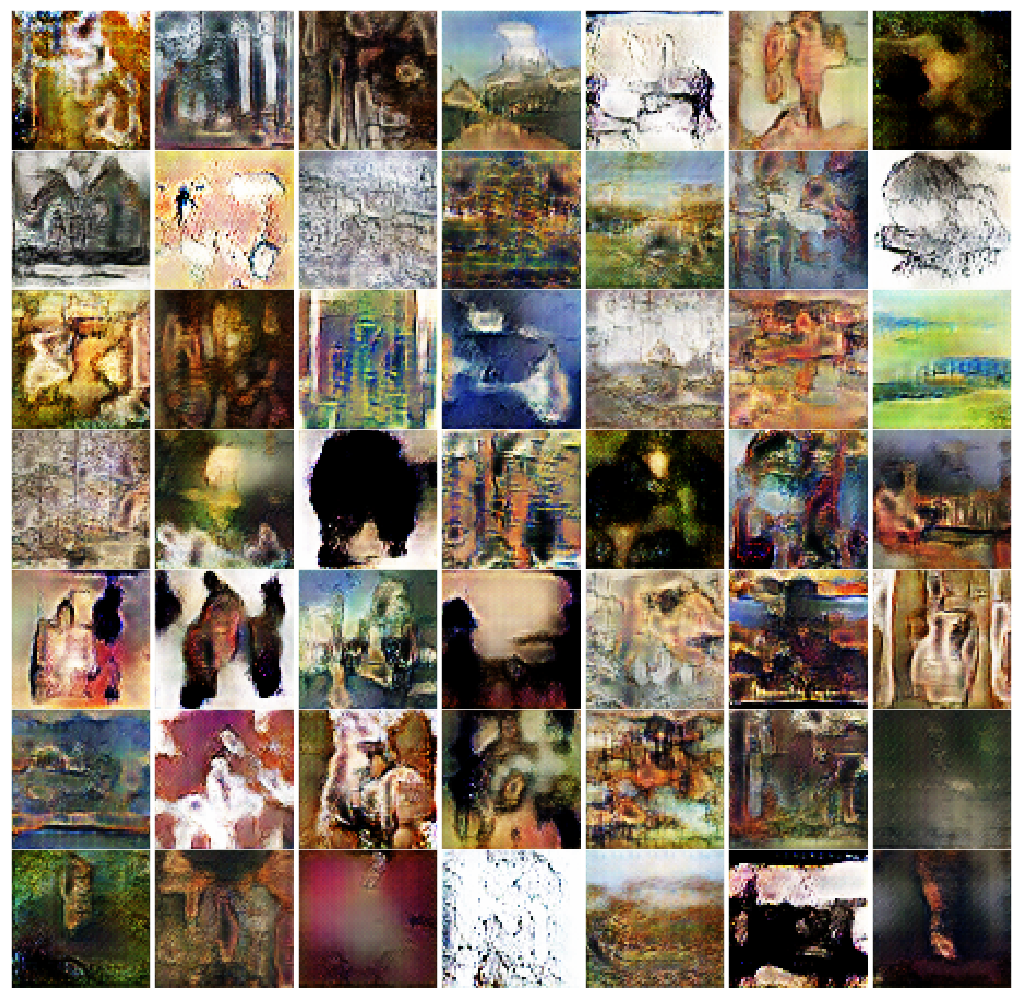

In [17]:
z = sample_z(49, 100)
#c = code.sample_continuous(49)
show_result(z)

In [8]:
interact_code(code)

interactive(children=(FloatSlider(value=0.0, description='c_1', max=5.0, min=-5.0), FloatSlider(value=0.0, description='c_2', max=5.0, min=-5.0), Output()), _dom_classes=('widget-interact',))

In [53]:
z = sample_z(1, latent_size - code.n_continuous)
interact_code(code, z=z)

interactive(children=(FloatSlider(value=0.0, description='c_1', max=5.0, min=-5.0), FloatSlider(value=0.0, description='c_2', max=5.0, min=-5.0), FloatSlider(value=0.0, description='c_3', max=5.0, min=-5.0), FloatSlider(value=0.0, description='c_4', max=5.0, min=-5.0), FloatSlider(value=0.0, description='c_5', max=5.0, min=-5.0), FloatSlider(value=0.0, description='c_6', max=5.0, min=-5.0), FloatSlider(value=0.0, description='c_7', max=5.0, min=-5.0), FloatSlider(value=0.0, description='c_8', max=5.0, min=-5.0), FloatSlider(value=0.0, description='c_9', max=5.0, min=-5.0), FloatSlider(value=0.0, description='c_10', max=5.0, min=-5.0), Output()), _dom_classes=('widget-interact',))

In [31]:
#res = pickle.load(open('results/saved_data/losses_paintings64_InfoGAN_128.p', 'rb'))
res = pickle.load(open('results/saved_data/losses_paintings64_InfoGAN_128.p', 'rb'))

In [32]:
def plot_results(**res):
    plt.figure(figsize=(18,6))
    i = 1
    for label, values in res.items():
        plt.subplot(1,3,i)
        plt.plot(values, label=label)
        plt.legend()
        i+=1
        
    plt.show()

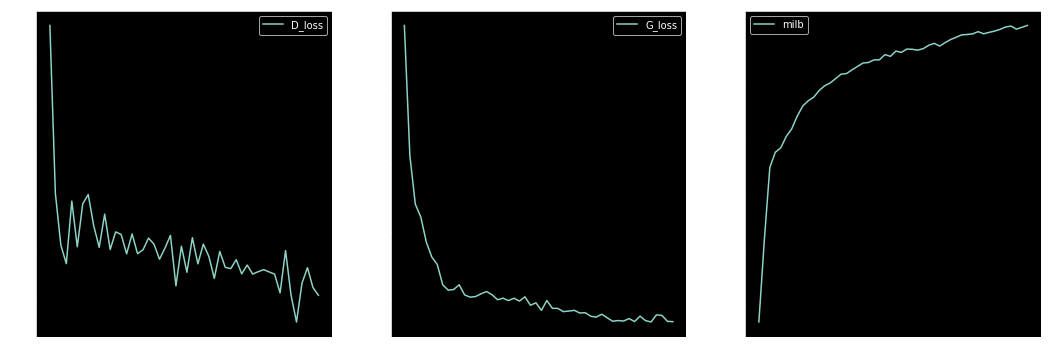

In [33]:
plot_results(**res)